In [1]:
import zarr
import numpy as np
from glob import glob

import time
from datetime import datetime, timedelta

In [2]:
# graph tools
import cartopy.crs as ccrs
#import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
#from cartopy.io.shapereader import Reader
#from cartopy.feature import ShapelyFeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
#from matplotlib.text import Text
#import matplotlib.lines as mlines
#import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

#from matplotlib import ticker
import matplotlib.ticker as mticker
#import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
%matplotlib inline

**data**

data obtained from WFRT.

In [4]:
filename = glob('../_data/*.zarr.zip')[0]

In [5]:
with zarr.open(filename) as group_io:
    print(group_io._info)
    #print(group_io.attrs.keys())
    print(group_io.attrs['MAP_PROJ_CHAR'])
    center_lon = float(group_io.attrs['CEN_LON'])
    ini_time = group_io.attrs['SIMULATION_START_DATE']
    xlat = group_io['XLAT'][...]
    xlon = group_io['XLONG'][...]
    times = group_io['Time'][...]
    F = group_io['F'][...]

Name        : /
Type        : zarr.hierarchy.Group
Read-only   : False
Store type  : zarr.storage.ZipStore
No. members : 11
No. arrays  : 10
No. groups  : 1
Arrays      : F, H, T, Time, W, WD, XLAT, XLONG, m_o, r_o


'Polar Stereographic'


**metadata**

In [6]:
# station name, longitude, latitude, ind_lat, ind_lon
stns = {
    "Vancouver": (-123.1207, 49.2827, 137, 196), 
    "Prince George": (-122.7497, 53.9171, 265, 233),
    "Fort St John": (-120.8464, 56.2524, 323, 276), 
    "Kamloops": (-120.3273, 50.6745, 166, 256), 
    "Creston": (-116.5, 49.083, 110, 319),
    "Prince Rupert": (-130.3208, 54.3150, 312, 116), 
    "Atlin": (-133.6895, 59.5780, 466, 123), 
    "Tofino": (-125.9066, 49.1530, 147, 144),
    "Fort Nelson": (-122.6972, 58.8050, 398, 263)
}

# ----- search nearest grid point ----- #
# from scipy.spatial import cKDTree
# gridTree = cKDTree(list(zip(xlon.ravel(), xlat.ravel())))
# grid_shape = xlon.shape
# for stnname, stnloc in stns.items():
#     dist, inds = gridTree.query((stnloc[0], stnloc[1]))
#     print(np.unravel_index(inds, grid_shape))
# ------------------------------ #


**loop of 2d figures**

* That Cartopy starts with your subsetted data in the target region.
* Use `pcolormesh` instead of `contours` and `pcolor`
* Move components out of the loop
* Do not add map features that will be overridden by your data.

0.14992761611938477 sec
0.16134262084960938 sec
0.1477963924407959 sec
0.14284944534301758 sec
0.1433107852935791 sec
0.15824103355407715 sec
0.1518392562866211 sec


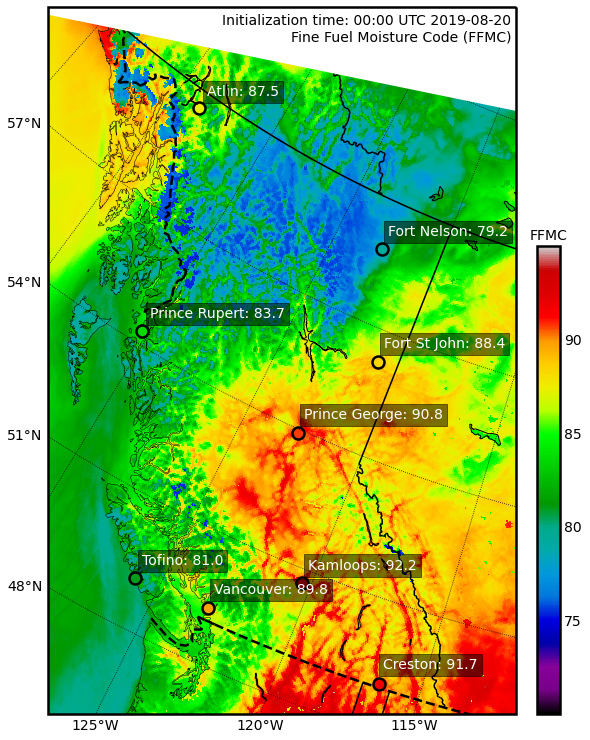

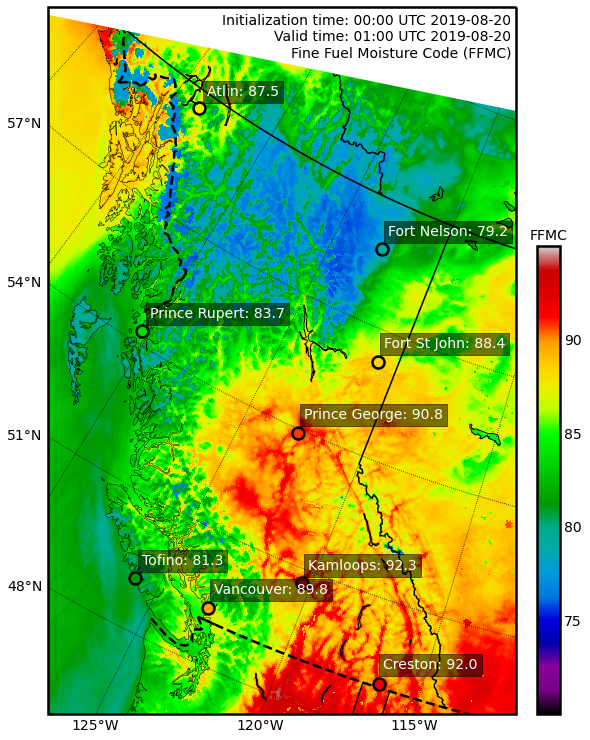

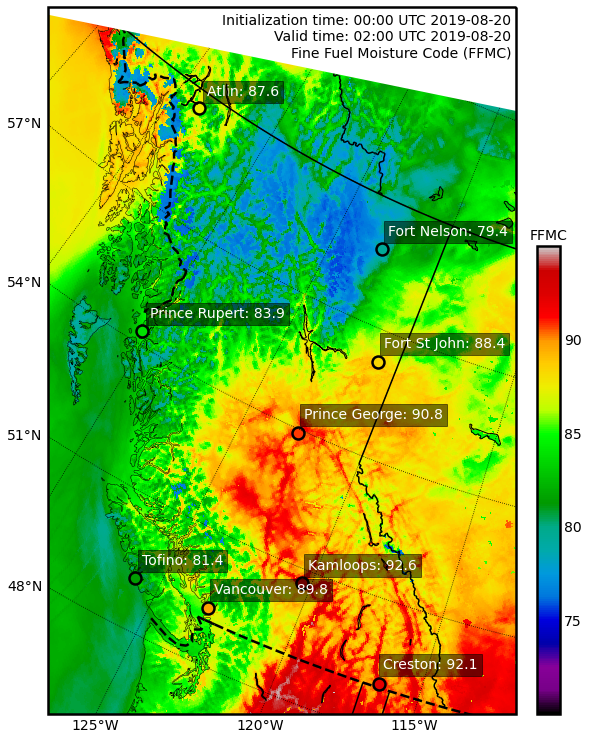

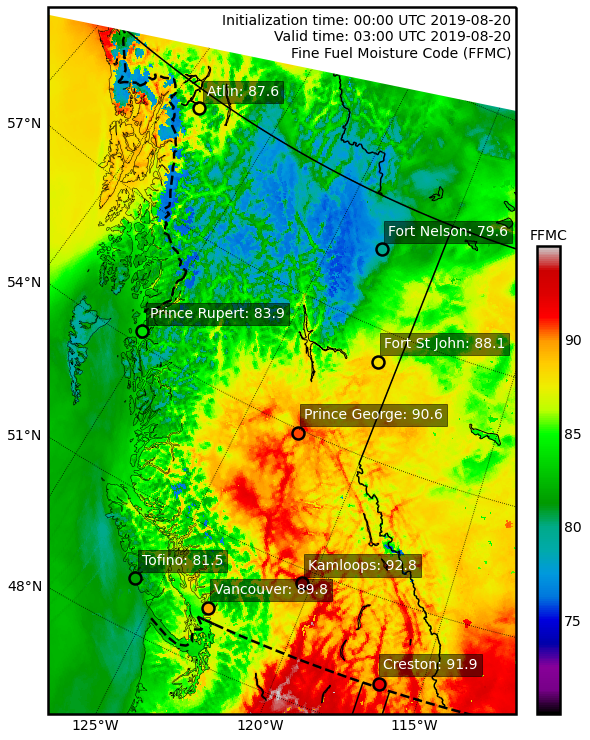

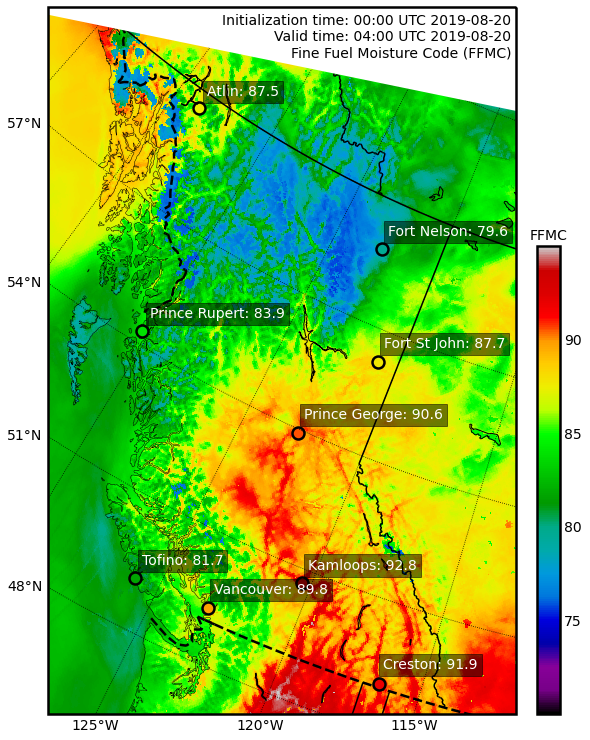

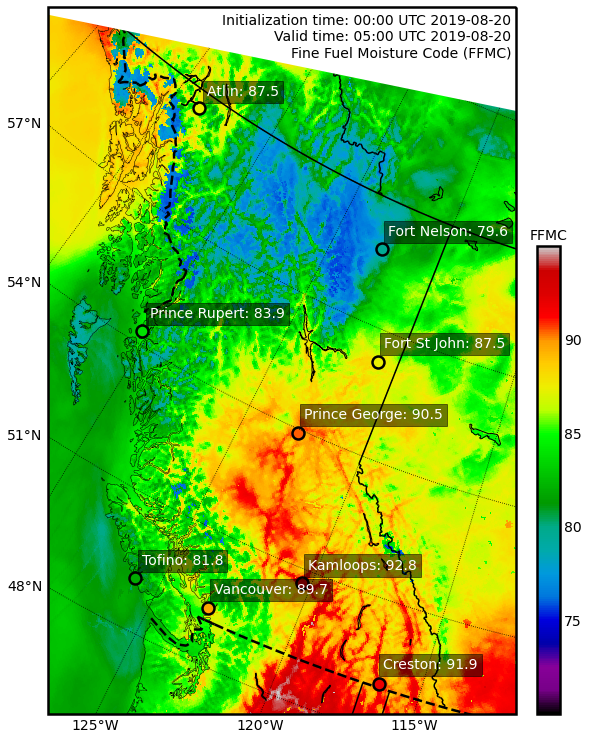

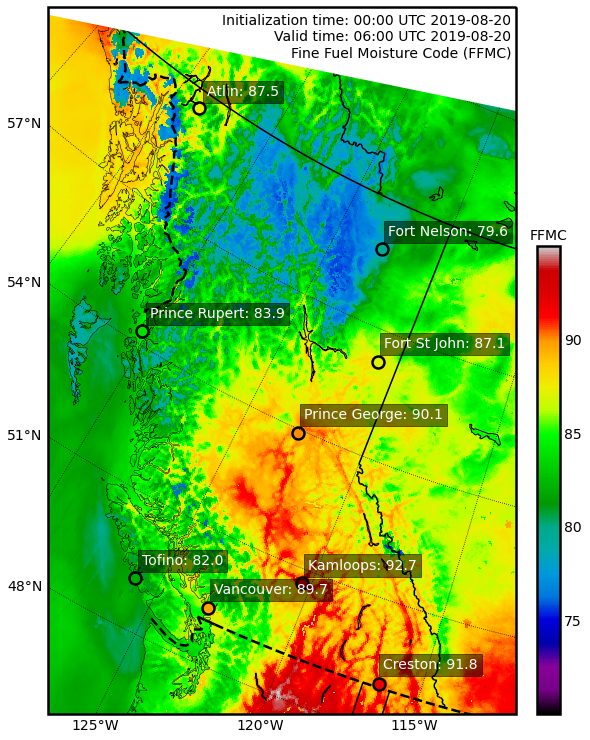

In [9]:
# subset data into BC
xlon = xlon[:, :450]
xlat = xlat[:, :450]
F = F[..., :450]
times = times[:7] # test the first 1+6 fcst lead times

# figure params
minmax = [70.001, 94.999]
firemap = plt.cm.nipy_spectral

# Cartopy map settings
scale_param = '10m'
edge = [-128, -120, 47.5, 64.25]
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                        scale=scale_param, facecolor='none')
proj_ = ccrs.NorthPolarStereo(central_longitude=center_lon)

# maskout figure top and create space for the title
mask_lon = np.array([-143, -118, -118, -140]) # <--- lat/lon scaled by edge=[-128, -120, 47.5, 64.25]
mask_lat = np.array([58.7, 63.3, 66, 66])
mask_out = proj_.transform_points(ccrs.PlateCarree(), mask_lon, mask_lat)
mask_points = np.vstack([mask_out[:, 0], mask_out[:, 1]]).T

# initialization
ini_dt = datetime.strptime(ini_time[1:-1], '%Y-%m-%d_%H:%M:%S')
ini_string = datetime.strftime(ini_dt, '%H:%M UTC %Y-%m-%d')

for i in range(len(times)):
    start_time = time.time()
    
    # -----
    F0 = F[i, ...] # time slice
    
    # ----- formulating the title string ----- #
    if i == 0:
        # initialization
        title_string = 'Initialization time: {}\nFine Fuel Moisture Code (FFMC)'.format(ini_string)
    else:
        # fcst field
        fcst_dt = ini_dt + timedelta(hours=int(times[i]))
        fcst_string = datetime.strftime(fcst_dt, '%H:%M UTC %Y-%m-%d')
        title_string = 'Initialization time: {}\nValid time: {}\nFine Fuel Moisture Code (FFMC)'.format(ini_string, fcst_string)
    
    # ----- figure ----- #
    fig = plt.figure(figsize=(13, 13))
    ax = fig.gca(projection=proj_)

    # ----- cartopy features (scale_param = 10 m) ----- #
    ax.set_extent(edge, ccrs.PlateCarree())
    ax.add_feature(cfeature.LAKES.with_scale(scale_param), facecolor='none', linewidth=1.0, edgecolor='k', zorder=5)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5, zorder=4)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=4)
    # bold edges
    ax.spines['geo'].set_linewidth(2.5)
    ax.spines['geo'].set_zorder(7)

    # ----- grid lines/labels ----- #
    # grid lines but labels only
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='k', linewidth=0, zorder=5)
    GL.top_labels = None
    GL.right_labels = None
    GL.xlocator = mticker.FixedLocator([-125, -120, -115])
    GL.ylocator = mticker.FixedLocator([48, 51, 54, 57])
    GL.xlabel_style = {'size': 14}
    GL.ylabel_style = {'size': 14}
    GL.rotate_labels = False
    # grid lines but lines only
    GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, x_inline=False, y_inline=False, color='k', linestyle=':', zorder=5)

    # -- title -- #
    ax.add_collection(PatchCollection([patches.Polygon(mask_points)], facecolor='w', edgecolor='none', linewidth=0, zorder=6))
    ax.text(0.99, 0.99, title_string, ha='right', va='top', fontsize=14, transform=ax.transAxes, zorder=7)
    
    # ----- pcolormesh ----- #
    CS = ax.pcolormesh(xlon, xlat, F0, vmin=minmax[0], vmax=minmax[1], cmap=firemap, transform=ccrs.PlateCarree(), zorder=4)

    # ----- station labels ----- #
    for stnname, stnloc in stns.items():
        # annotation location subtracted from latitudes
        lat_pad = 0.35 # <----- scaled by figsize=(13, 13)
        
        # scatter with color repreents the F value
        ax.scatter(stnloc[0], stnloc[1], c=F0[stnloc[2], stnloc[3]], vmin=minmax[0], vmax=minmax[1], cmap=firemap,
                   marker='o', s=12*12, edgecolor='k', linewidth=2.5, transform=ccrs.PlateCarree(), zorder=5)
        # station name and F value
        ax.annotate(stnname+': {:.1f}'.format(F0[stnloc[2], stnloc[3]]), xy=stnloc[:2], color='w', fontsize=14, 
                    xytext=(stnloc[0], stnloc[1]+lat_pad), bbox=dict(fc='k', alpha=0.5),
                    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), zorder=5)

    # ----- colorbar ----- #
    ax_base = fig.add_axes([0.785, 0.125, 0.05, 0.5]) # <----- scaled by figsize=(13, 13)
    [j.set_linewidth(0) for j in ax_base.spines.values()]
    ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                        labelleft=False, labeltop=False, labelright=False, labelbottom=False)
    cax = inset_axes(ax_base, width='50%', height='100%', borderpad=0, loc=6)
    CBar = plt.colorbar(CS, orientation='vertical', cax=cax)
    CBar.ax.set_title('FFMC', fontsize=14)
    CBar.ax.tick_params(axis='y', labelsize=14, direction='in', length=0)
    CBar.outline.set_linewidth(2.5)

    print("%s sec" % (time.time() - start_time))